In [16]:
!pip3 install tensorflow

In [17]:
import tensorflow as tf

print(tf.__version__)

2.12.0


In [18]:
    Directory_Training_ = 'C:/Users/Dell/Desktop/asl_alphabet_train/asl_alphabet_train/'
    Directory_Testing = 'C:/Users/Dell/Desktop/asl_alphabet_test/asl_alphabet_test/'

In [19]:
!pip install opencv-python

In [20]:
#%matplotlib inline  # Enables displaying plots directly in the Jupyter Notebook or IPython environment


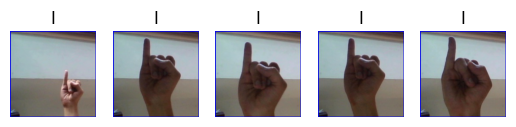

In [21]:

import numpy as nps_  # Library for numerical operations
import matplotlib.image as mpimgs_  # Library for reading and displaying images
import matplotlib.pyplot as plts_  # Library for plotting and visualization

import cv2  # Library for image processing
import os  # Library for file and directory operations
import random  # Library for generating random numbers

row_number = 1  # Number of rows for subplots
column_number = 5  # Number of columns for subplots

CATS = os.listdir(Directory_Training_)  # Get the list of categories (folders) in the training directory

random.seed(13)  # Set a random seed for reproducibility

CAT = CATS[random.randint(1, 30)]  # Select a random category from the list

for j in range(column_number):
    subplot = plts_.subplot(row_number, column_number, j + 1)  # Create a subplot for each image
    subplot.axis('Off')  # Turn off the subplot's axis
    subplot.set_title(CAT)  # Set the title of the subplot
    
    image_path = os.path.join(
        Directory_Training_,
        str(CAT),
        str(CAT) + str(random.randint(1, 1000)) + '.jpg'
    )  # Generate a random image path for the selected category
    
    img_ = mpimgs_.imread(image_path)  # Read the image from the generated path
    plts_.imshow(img_)  # Display the image on the subplot
  
plts_.show()  # Show the subplots


In [22]:
!pip install --upgrade tensorflow

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator as  Image_Data_Gen_ # Library for image data preprocessing

Size_of_image = 200  # Size of the images (width and height)
Size_of_batch = 64  # Number of images per batch

# Data augmentation and preprocessing settings
Gen_Data_ = Image_Data_Gen_(
    samplewise_center=True,  # Normalize each image by subtracting the mean
    samplewise_std_normalization=True,  # Normalize each image by dividing by the standard deviation
    brightness_range=[0.8, 1.0],  # Randomly adjust brightness of the images
    zoom_range=[1.0, 1.2],  # Randomly zoom into the images
    validation_split=0.1  # Split the data into training and validation sets (90% training, 10% validation)
)

# Generate training data from the training directory
Gen_Train_ = Gen_Data_.flow_from_directory(
    Directory_Training_,
    target_size=(Size_of_image, Size_of_image),  # Resize images to the specified size
    shuffle=True,  # Shuffle the order of the images
    seed=13,  # Set a random seed for reproducibility
    class_mode='categorical',  # Use categorical labels
    batch_size=Size_of_batch,  # Number of images per batch
    subset="training"  # Subset of the data (training set)
)

# Generate validation data from the training directory
Gen_Validation_ = Gen_Data_.flow_from_directory(
    Directory_Training_,
    target_size=(Size_of_image, Size_of_image),  # Resize images to the specified size
    shuffle=True,  # Shuffle the order of the images
    seed=13,  # Set a random seed for reproducibility
    class_mode='categorical',  # Use categorical labels
    batch_size=Size_of_batch,  # Number of images per batch
    subset="validation"  # Subset of the data (validation set)
)


Found 78300 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.


In [24]:
!pip install wget

In [25]:
import wget  # Library for downloading files from the web

URL1_ = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

wget.download(URL1_)


100% [........................................................................] 87910968 / 87910968

'inception_v3_weights_tf_dim_ordering_tf_kernels_notop (8).h5'

In [26]:
from tensorflow.keras import layers  # Library for building neural network layers
from tensorflow.keras import Model  # Class for creating custom models

from tensorflow.keras.applications.inception_v3 import InceptionV3  # Pre-trained InceptionV3 model

WEIGHTS_FILE = 'c:/Users/Chandana/OneDrive/Desktop/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

inception_v3_model = InceptionV3(
    input_shape=(Size_of_image, Size_of_image, 3), 
    include_top=False, 
    weights='imagenet'
)
model = inception_v3_model

# Freeze the layers except for the last 2 blocks
for layer in model.layers[:249]:
    layer.trainable = False

# Unfreeze the layers in the last 2 blocks
for layer in model.layers[249:]:
    layer.trainable = True

inception_v3_model.summary()


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 99, 99, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 99, 99, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                       

In [27]:
# Get the output layer of the InceptionV3 model
InceptionOutputLayer = inception_v3_model.get_layer('mixed7')

# Print the shape of the output layer
print('Shape of Inception model output:', InceptionOutputLayer.output_shape)

# Assign the output of the InceptionV3 model to a variable
OutputInception = inception_v3_model.output


Shape of Inception model output: (None, 10, 10, 768)


In [28]:
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

# Apply Global Average Pooling to the output of the InceptionV3 model
x = layers.GlobalAveragePooling2D()(OutputInception)

# Add a Dense layer with 1024 units and ReLU activation function
x = layers.Dense(1024, activation='relu')(x)

# Add a Dense layer with 29 units and softmax activation function
x = layers.Dense(29, activation='softmax')(x)

# Create a new model with the modified architecture
model = Model(inception_v3_model.input, x)

# Compile the model with specified optimizer, loss function, and metrics
model.compile(
    optimizer=SGD(lr=0.0001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['acc']
)


In [29]:
ThresholdLoss_ = 0.2
ThresholdAccuracy_ = 0.95

# Custom callback class to stop training when certain conditions are met
class ModelCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        # Check if validation loss is below the threshold and validation accuracy is above the threshold
        if logs.get('val_loss') <= ThresholdLoss_ and logs.get('val_acc') >= ThresholdAccuracy_:
            print("\nReached", ThresholdAccuracy_ * 100, "accuracy, Stopping!")
            self.model.stop_training = True

# Create an instance of the custom callback
callback = ModelCallback()


In [30]:
History_ = model.fit_generator(
    Gen_Train_,  # Training data generator
    validation_data=Gen_Validation_,  # Validation data generator
    steps_per_epoch=50,  # Number of batches per epoch during training
    validation_steps=20,  # Number of batches per validation
    epochs=20,  # Number of training epochs
    callbacks=[callback]  # Callback function for monitoring training
)


C:\Users\Dell\AppData\Local\Temp\ipykernel_6628\337098752.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  History_ = model.fit_generator(


Epoch 1/20
50/50 [==============================] - 149s 3s/step - loss: 1.7339 - acc: 0.5584 - val_loss: 2.3502 - val_acc: 0.4367
Epoch 2/20
50/50 [==============================] - 160s 3s/step - loss: 0.3897 - acc: 0.8863 - val_loss: 0.8949 - val_acc: 0.7117
Epoch 3/20
50/50 [==============================] - 173s 3s/step - loss: 0.1970 - acc: 0.9366 - val_loss: 0.5672 - val_acc: 0.8250
Epoch 4/20
50/50 [==============================] - 159s 3s/step - loss: 0.1638 - acc: 0.9484 - val_loss: 0.4727 - val_acc: 0.8453
Epoch 5/20
50/50 [==============================] - 167s 3s/step - loss: 0.1261 - acc: 0.9600 - val_loss: 0.6561 - val_acc: 0.8297
Epoch 6/20
50/50 [==============================] - 158s 3s/step - loss: 0.1132 - acc: 0.9675 - val_loss: 0.4753 - val_acc: 0.8586
Epoch 7/20
50/50 [==============================] - 160s 3s/step - loss: 0.0824 - acc: 0.9734 - val_loss: 0.5259 - val_acc: 0.8375
Epoch 8/20
50/50 [==============================] - 158s 3s/step - loss: 0.0553 - a

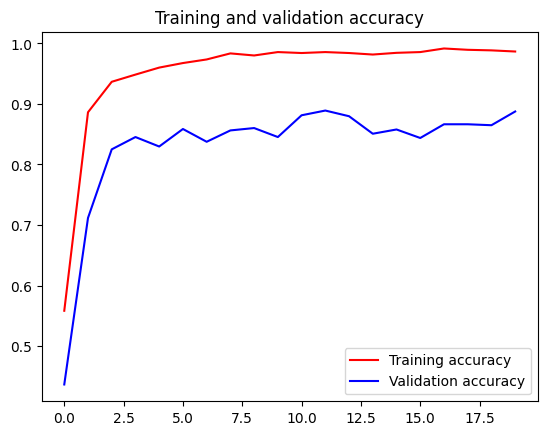

<Figure size 640x480 with 0 Axes>

In [31]:
import matplotlib.pyplot as plts_

# Extracting the training and validation metrics from the training history
acc = History_.history['acc']
val_acc = History_.history['val_acc']
loss = History_.history['loss']
val_loss = History_.history['val_loss']

epochs = range(len(acc))

# Plotting the training and validation accuracy
plts_.plot(epochs, acc, 'r', label='Training accuracy')  # Plotting training accuracy values in red
plts_.plot(epochs, val_acc, 'b', label='Validation accuracy')  # Plotting validation accuracy values in blue
plts_.title('Training and validation accuracy')  # Setting the title of the plot
plts_.legend(loc=0)  # Adding a legend to the plot
plts_.figure()  # Creating a new figure

# Displaying the plot
plts_.show()


<Figure size 640x480 with 0 Axes>

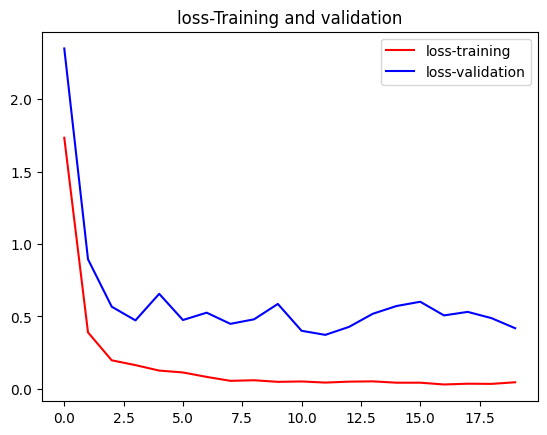

<Figure size 640x480 with 0 Axes>

In [32]:
plts_.plot(epochs, loss, 'r', label='loss-training')  # Plotting training loss values in red
plts_.plot(epochs, val_loss, 'b', label='loss-validation')  # Plotting validation loss values in blue
plts_.title('loss-Training and validation')  # Setting the title of the plot
plts_.legend(loc=0)  # Adding a legend to the plot
plts_.figure()  # Creating a new figure

In [33]:
NameModel_ = 'models/asl_alphabet_{}.h5'.format(9575)
model.save(NameModel_)

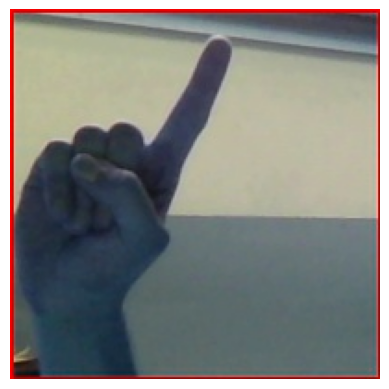

In [35]:
import cv2
import numpy as nps_
import os
import matplotlib.pyplot as plts_

# Obtaining the list of classes from the training directory and sorting them
Classes_ = os.listdir(Directory_Training_)
Classes_.sort()

# Iterating over the test images in the testing directory
for i, TestImage_ in enumerate(os.listdir(Directory_Testing)):
    # Obtaining the image location
    image_location = Directory_Testing + TestImage_    
    # Reading the image using OpenCV
img = cv2.imread(image_location)
    
    # Resizing the image to the desired size
    
img = cv2.resize(img, (Size_of_image, Size_of_image))
    
    # Creating a new figure for displaying the image
plts_.figure()
    
    # Turning off the axes for the plot
plts_.axis('Off')
    
    # Displaying the image using imshow
plts_.imshow(img)

C:/Users/Dell/Desktop/asl_alphabet_test/asl_alphabet_test/A_test.jpg
1/1 [==============================] - 1s 892ms/step
Actual class: A 
 Predicted class: A


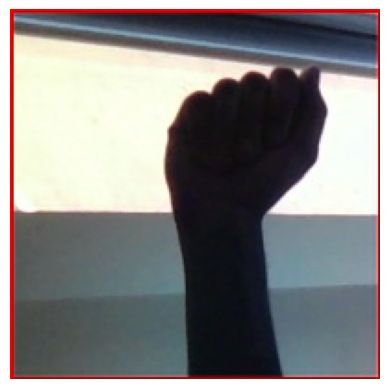

C:/Users/Dell/Desktop/asl_alphabet_test/asl_alphabet_test/B_test.jpg
1/1 [==============================] - 0s 52ms/step
Actual class: B 
 Predicted class: B


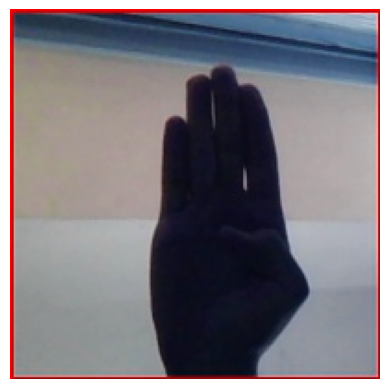

C:/Users/Dell/Desktop/asl_alphabet_test/asl_alphabet_test/C_test.jpg
1/1 [==============================] - 0s 57ms/step
Actual class: C 
 Predicted class: C


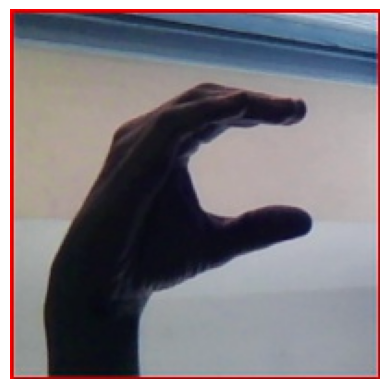

C:/Users/Dell/Desktop/asl_alphabet_test/asl_alphabet_test/D_test.jpg
1/1 [==============================] - 0s 42ms/step
Actual class: D 
 Predicted class: D


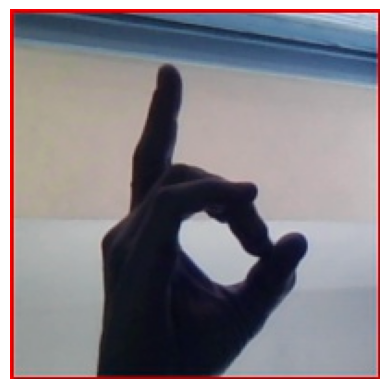

C:/Users/Dell/Desktop/asl_alphabet_test/asl_alphabet_test/E_test.jpg
1/1 [==============================] - 0s 35ms/step
Actual class: E 
 Predicted class: E


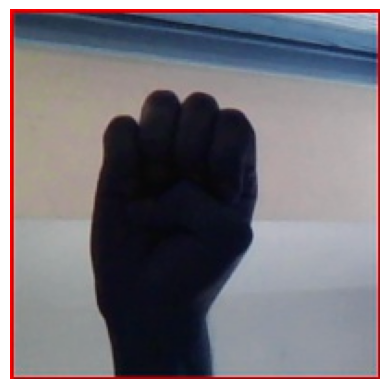

C:/Users/Dell/Desktop/asl_alphabet_test/asl_alphabet_test/F_test.jpg
1/1 [==============================] - 0s 42ms/step
Actual class: F 
 Predicted class: F


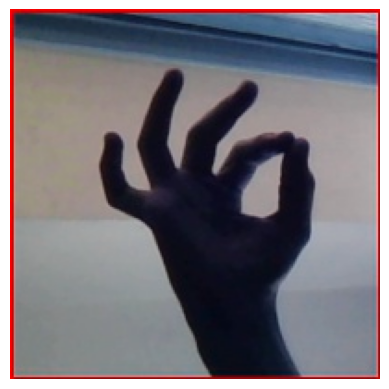

C:/Users/Dell/Desktop/asl_alphabet_test/asl_alphabet_test/G_test.jpg
1/1 [==============================] - 0s 42ms/step
Actual class: G 
 Predicted class: G


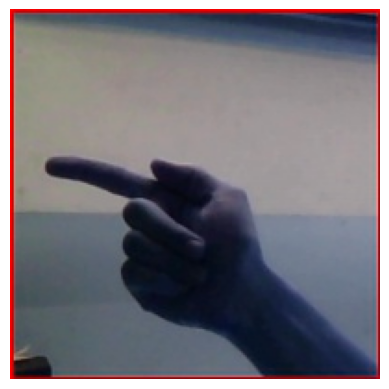

C:/Users/Dell/Desktop/asl_alphabet_test/asl_alphabet_test/H_test.jpg
1/1 [==============================] - 0s 46ms/step
Actual class: H 
 Predicted class: H


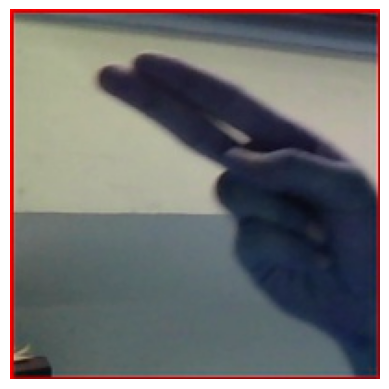

C:/Users/Dell/Desktop/asl_alphabet_test/asl_alphabet_test/I_test.jpg
1/1 [==============================] - 0s 40ms/step
Actual class: I 
 Predicted class: I


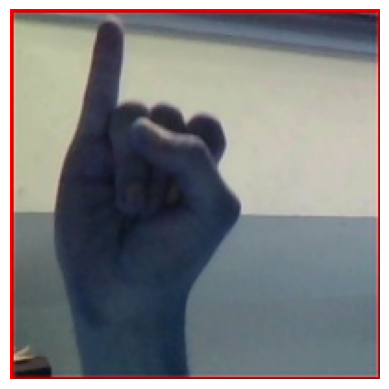

C:/Users/Dell/Desktop/asl_alphabet_test/asl_alphabet_test/J_test.jpg
1/1 [==============================] - 0s 39ms/step
Actual class: J 
 Predicted class: J


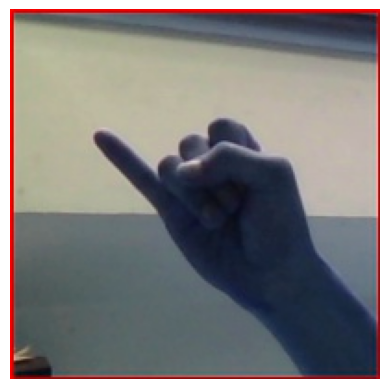

C:/Users/Dell/Desktop/asl_alphabet_test/asl_alphabet_test/K_test.jpg
1/1 [==============================] - 0s 51ms/step
Actual class: K 
 Predicted class: K


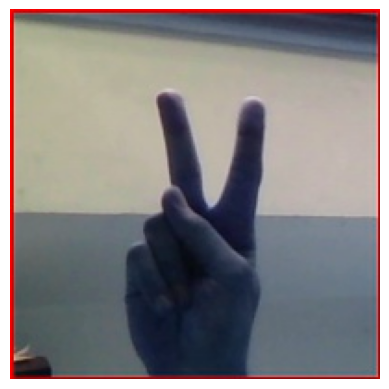

C:/Users/Dell/Desktop/asl_alphabet_test/asl_alphabet_test/L_test.jpg
1/1 [==============================] - 0s 47ms/step
Actual class: L 
 Predicted class: L


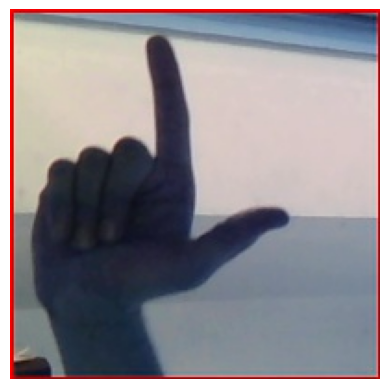

C:/Users/Dell/Desktop/asl_alphabet_test/asl_alphabet_test/M_test.jpg
1/1 [==============================] - 0s 46ms/step
Actual class: M 
 Predicted class: M


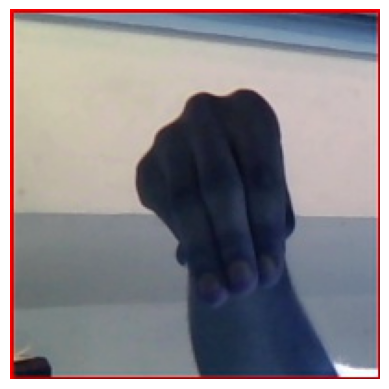

C:/Users/Dell/Desktop/asl_alphabet_test/asl_alphabet_test/nothing_test.jpg
1/1 [==============================] - 0s 64ms/step
Actual class: nothing 
 Predicted class: nothing


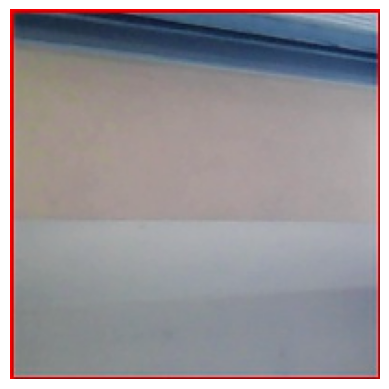

C:/Users/Dell/Desktop/asl_alphabet_test/asl_alphabet_test/N_test.jpg
1/1 [==============================] - 0s 47ms/step
Actual class: N 
 Predicted class: N


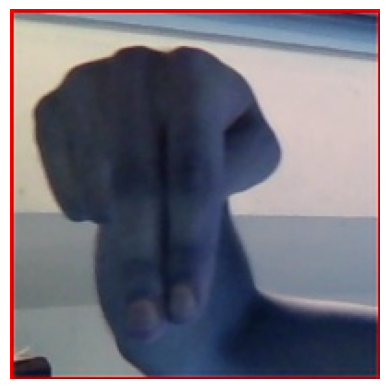

C:/Users/Dell/Desktop/asl_alphabet_test/asl_alphabet_test/O_test.jpg
1/1 [==============================] - 0s 49ms/step
Actual class: O 
 Predicted class: O


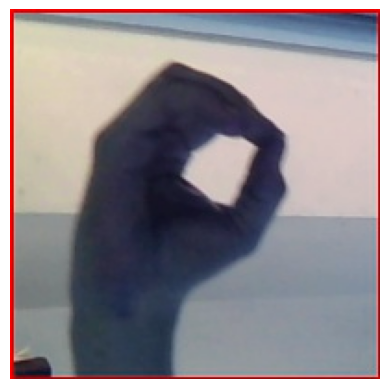

C:/Users/Dell/Desktop/asl_alphabet_test/asl_alphabet_test/P_test.jpg
1/1 [==============================] - 0s 49ms/step
Actual class: P 
 Predicted class: P


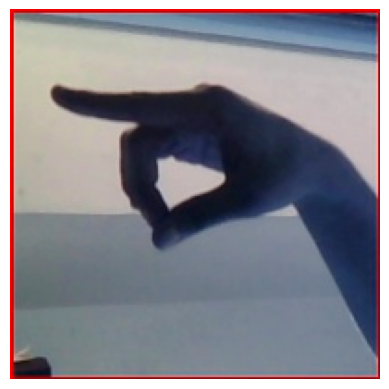

C:/Users/Dell/Desktop/asl_alphabet_test/asl_alphabet_test/Q_test.jpg
1/1 [==============================] - 0s 58ms/step
Actual class: Q 
 Predicted class: Q


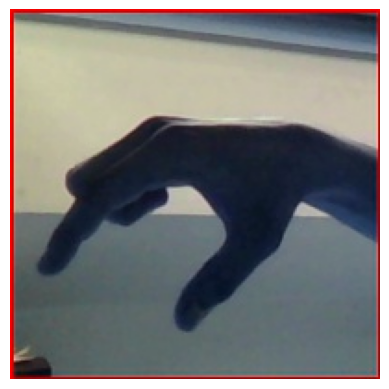

C:/Users/Dell/Desktop/asl_alphabet_test/asl_alphabet_test/R_test.jpg
1/1 [==============================] - 0s 43ms/step
Actual class: R 
 Predicted class: R


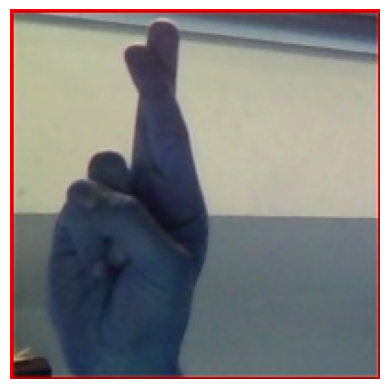

C:/Users/Dell/Desktop/asl_alphabet_test/asl_alphabet_test/space_test.jpg
1/1 [==============================] - 0s 67ms/step
Actual class: space 
 Predicted class: space


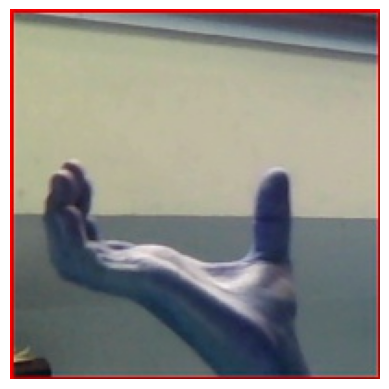

C:/Users/Dell/Desktop/asl_alphabet_test/asl_alphabet_test/S_test.jpg
1/1 [==============================] - 0s 29ms/step
Actual class: S 
 Predicted class: S


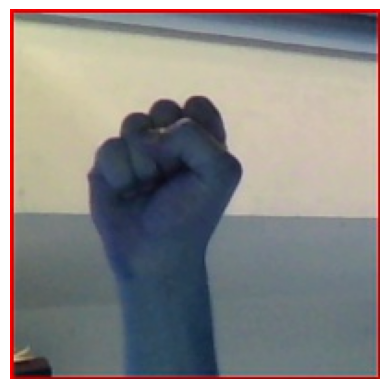

C:/Users/Dell/Desktop/asl_alphabet_test/asl_alphabet_test/T_test.jpg
1/1 [==============================] - 0s 44ms/step
Actual class: T 
 Predicted class: T


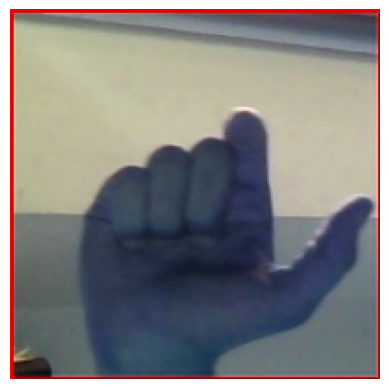

C:/Users/Dell/Desktop/asl_alphabet_test/asl_alphabet_test/U_test.jpg
1/1 [==============================] - 0s 46ms/step
Actual class: U 
 Predicted class: U


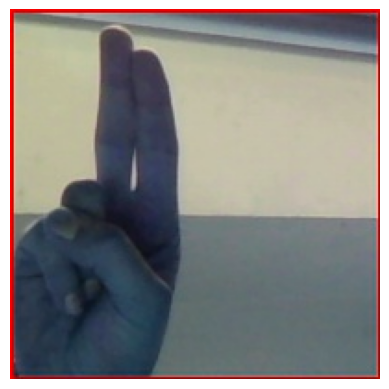

C:/Users/Dell/Desktop/asl_alphabet_test/asl_alphabet_test/V_test.jpg
1/1 [==============================] - 0s 46ms/step
Actual class: V 
 Predicted class: V


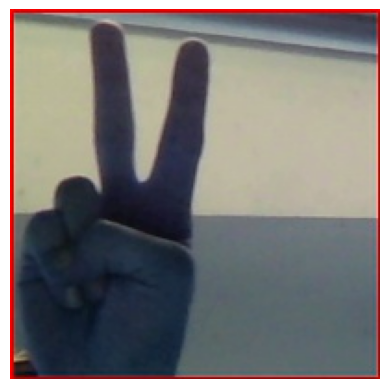

C:/Users/Dell/Desktop/asl_alphabet_test/asl_alphabet_test/W_test.jpg
1/1 [==============================] - 0s 53ms/step
Actual class: W 
 Predicted class: W


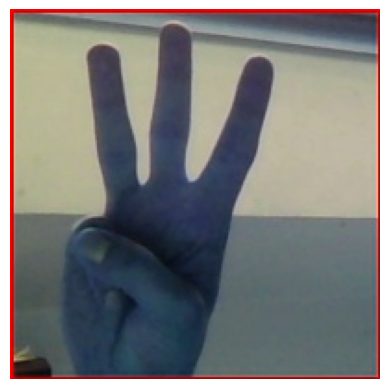

C:/Users/Dell/Desktop/asl_alphabet_test/asl_alphabet_test/X_test.jpg
1/1 [==============================] - 0s 44ms/step
Actual class: X 
 Predicted class: X


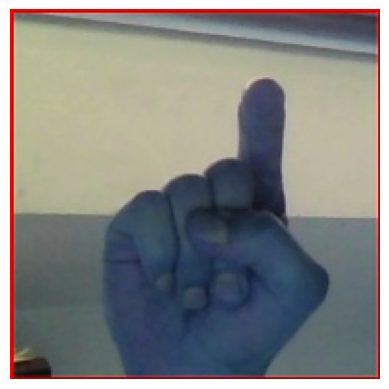

C:/Users/Dell/Desktop/asl_alphabet_test/asl_alphabet_test/Y_test.jpg
1/1 [==============================] - 0s 46ms/step
Actual class: Y 
 Predicted class: Y


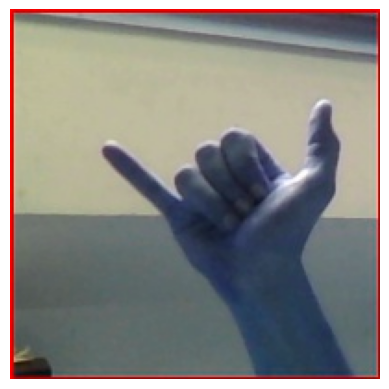

C:/Users/Dell/Desktop/asl_alphabet_test/asl_alphabet_test/Z_test.jpg
1/1 [==============================] - 0s 67ms/step
Actual class: Z 
 Predicted class: Z


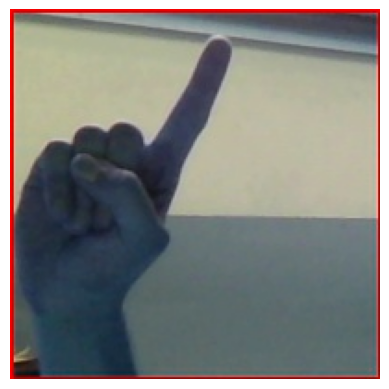

In [36]:
import cv2
import numpy as nps_
import os
import matplotlib.pyplot as plts_

# Obtaining the list of classes from the training directory and sorting them
Classes_ = os.listdir(Directory_Training_)
Classes_.sort()

# Iterating over the test images in the testing directory
for i, TestImage_ in enumerate(os.listdir(Directory_Testing)):
    # Obtaining the image location
    image_location = Directory_Testing + TestImage_ 
    print(image_location)
    
    # Reading the image using OpenCV
    img = cv2.imread(image_location)
    
    # Resizing the image to the desired size
    
    img = cv2.resize(img, (Size_of_image, Size_of_image))
    
    # Creating a new figure for displaying the image
    plts_.figure()
    
    # Turning off the axes for the plot
    plts_.axis('Off')
    
    # Displaying the image using imshow
    plts_.imshow(img)
    
    # Converting the image to a numpy array and normalizing its values
    img = nps_.array(img) / 255.
    
    # Reshaping the image to match the input shape expected by the model
    img = img.reshape((1, Size_of_image, Size_of_image, 3))
    
    # Standardizing the image using the data generator
    img = Gen_Data_.standardize(img)
    
    # Making a prediction on the image using the model
    prediction = nps_.array(model.predict(img))
    
    # Extracting the actual and predicted class labels
    actual = TestImage_.split('_')[0]
    predicted = Classes_[prediction.argmax()]
    
    # Printing the actual and predicted class labels
    print('Actual class: {} \n Predicted class: {}'.format(actual, predicted))
    
    # Displaying the plotted image
    plts_.show()


In [37]:
# Obtaining the list of test images from the testing directory
ImagesTest_ = os.listdir(Directory_Testing)

# Calculating the total number of test cases
TestCasesTotal_ = len(ImagesTest_)

# Initializing counters for correctly classified and misclassified images
ClassifiedCorrectlyTotal_ = 0
total_misclassified = 0

# Iterating over the test images
for i, TestImage_ in enumerate(ImagesTest_):
    # Obtaining the image location
    image_location = Directory_Testing + TestImage_
    
    # Reading the image using OpenCV
    img = cv2.imread(image_location)
    
    # Resizing the image to the desired size
    img = cv2.resize(img, (Size_of_image, Size_of_image))
    
    # Converting the image to a numpy array and normalizing its values
    img = nps_.array(img) / 255.
    
    # Reshaping the image to match the input shape expected by the model
    img = img.reshape((1, Size_of_image, Size_of_image, 3))
    
    # Standardizing the image using the data generator
    img = Gen_Data_.standardize(img)
    
    # Making a prediction on the image using the model
    prediction = nps_.array(model.predict(img))
    
    # Extracting the actual and predicted class labels
    actual = TestImage_.split('_')[0]
    predicted = Classes_[prediction.argmax()]
    
    # Printing the actual and predicted class labels
    print('Actual class: {} - Predicted class: {}'.format(actual, predicted), end=' ')
    
    # Checking if the actual and predicted classes match
    if actual == predicted:
        print('PASS')
        ClassifiedCorrectlyTotal_ += 1
    else:
        print('FAIL')
        total_misclassified += 1

print("=" * 20)

# Calculating the accuracy and error rate of the test
AccuracyTest_ = (ClassifiedCorrectlyTotal_ / TestCasesTotal_) * 100
ErrorRateTest_ = (total_misclassified / TestCasesTotal_) * 100

# Printing the test metrics
print('Accuracy - Test:', AccuracyTest_)
print('Error rate - Test:', ErrorRateTest_)
print('Misclassified Classes:', total_misclassified)
print('Correctly classified Classes', ClassifiedCorrectlyTotal_)


1/1 [==============================] - 0s 32ms/step
Actual class: A - Predicted class: A PASS
1/1 [==============================] - 0s 27ms/step
Actual class: B - Predicted class: B PASS
1/1 [==============================] - 0s 47ms/step
Actual class: C - Predicted class: C PASS
1/1 [==============================] - 0s 47ms/step
Actual class: D - Predicted class: D PASS
1/1 [==============================] - 0s 59ms/step
Actual class: E - Predicted class: E PASS
1/1 [==============================] - 0s 42ms/step
Actual class: F - Predicted class: F PASS
1/1 [==============================] - 0s 43ms/step
Actual class: G - Predicted class: G PASS
1/1 [==============================] - 0s 42ms/step
Actual class: H - Predicted class: H PASS
1/1 [==============================] - 0s 41ms/step
Actual class: I - Predicted class: I PASS
1/1 [==============================] - 0s 41ms/step
Actual class: J - Predicted class: J PASS
1/1 [==============================] - 0s 52ms/step
Actual c

In [38]:
!pip install nbconvert

In [39]:
!pip install pyppeteer